<a href="https://colab.research.google.com/github/angelostefanini/data_analytics/blob/main/Waze_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waze Project
# Build a machine learning model

The purpose of this model is to find factors that drive user churn.

The goal of this model is to predict whether or not a Waze user is retained or churned.

"Thank you for providing the details for the final phase of the prediction algorithm we have requested. I apologize for missing many of the weekly project meetings, but I’ve been keeping informed of your progress. We discussed in detail your proposal for building and testing the following models for prediction: random forest and XGBoost."

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [2]:
df0 = pd.read_csv('waze_dataset_.csv')

In [3]:
df0.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


**Task 2. Feature engineering**
We have already prepared much of this data and performed exploratory data analysis (EDA). We know that some features had stronger correlations with churn than others, and you also created some features that may be useful.

In this part of the project, we will engineer these features and some new features to use for modeling.

To begin, create a copy of df0 to preserve the original dataframe. Call the copy df.

In [4]:
# Copy the df0 dataframe
df = df0.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


Creo la feature km_per_driving_day`

In [6]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

# 2. Get descriptive stats
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,1.499900e+04
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,inf
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,NaN
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,3.022063e+00
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,1.672804e+02
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,3.231459e+02
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,7.579257e+02
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,inf


In [7]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

**percent_sessions_in_last_month**
Create a new column percent_sessions_in_last_month that represents the percentage of each user's total sessions that were logged in their last month of use.

In [8]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

**professional_driver**

Create a new, binary feature called professional_driver that is a 1 for users who had 60 or more drives and drove on 15+ days in the last month.

In [9]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

total_sessions_per_day

Now, create a new column that represents the mean number of sessions per day since onboarding.

In [10]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [11]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,578.963113,0.449255,0.172945,0.338698
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,1030.094384,0.286919,0.378212,1.314333
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000298
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.196221,0.000000,0.051037
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.423097,0.000000,0.100775
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.687216,0.000000,0.216269
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15420.234110,1.530637,1.000000,39.763874


km_per_hour

Create a column representing the mean kilometers per hour driven in the last month.

In [12]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / df['duration_minutes_drives'] /60

df['km_per_hour'].describe()

count    14999.000000
mean         0.052887
std          0.092965
min          0.020004
25%          0.025196
50%          0.033995
75%          0.053647
max          6.567478
Name: km_per_hour, dtype: float64

km_per_drive

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature

In [13]:
# Create `km_per_drive` feature

df['km_per_drive'] = df['driven_km_drives'] / df['drives']

df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [14]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive'] == np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

percent_of_sessions_to_favorite

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [15]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_sessions_to_favorite, dtype: float64

**Drop missing values**

Because we know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the label column, and because these observations comprise less than 5% of the data, use the dropna() method to drop the rows that are missing this data.

In [16]:
# Drop rows with missing values
df.isna().sum()

ID                                  0
label                             700
sessions                            0
drives                              0
total_sessions                      0
n_days_after_onboarding             0
total_navigations_fav1              0
total_navigations_fav2              0
driven_km_drives                    0
duration_minutes_drives             0
activity_days                       0
driving_days                        0
device                              0
km_per_driving_day                  0
percent_sessions_in_last_month      0
professional_driver                 0
total_sessions_per_day              0
km_per_hour                         0
km_per_drive                        0
percent_sessions_to_favorite        0
dtype: int64

In [17]:
df = df.dropna(subset=['label'])

Task 4. Outliers

You know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

Task 5. Variable encoding

Dummying features
In order to use device as an X variable, you will need to convert it to binary, since this variable is categorical.

In cases where the data contains many categorical variables, you can use pandas built-in pd.get_dummies(), or you can use scikit-learn's OneHotEncoder() function.

Note: Each possible category of each feature will result in a feature for your model, which could lead to an inadequate ratio of features to observations and/or difficulty understanding your model's predictions.

Because this dataset only has one remaining categorical feature (device), it's not necessary to use one of these special functions. You can just implement the transformation directly.

Create a new, binary column called device2 that encodes user devices as follows:

Android -> 0
iPhone -> 1

In [18]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

<ipython-input-18-3c07782c93a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device2'] = np.where(df['device']=='Android', 0, 1)


,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


Target encoding
The target variable is also categorical, since a user is labeled as either "churned" or "retained." Change the data type of the label column to be binary. This change is needed to train the models.

Assign a 0 for all retained users.

Assign a 1 for all churned users.

Save this variable as label2 so as not to overwrite the original label variable.

Note: There are many ways to do this. Consider using np.where() as you did earlier in this notebook.

In [19]:
# Create binary `label2` column
df['label2'] = np.where(df['label'] == 'retained', 0, 1)
df[['label','label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


Task 6. Feature selection
Tree-based models can handle multicollinearity, so the only feature that can be cut is ID, since it doesn't contain any information relevant to churn.

Note, however, that device won't be used simply because it's a copy of device2.

Drop ID from the df dataframe.

In [20]:
# Drop `ID` column
df = df.drop(columns=['ID'])

In [21]:
df.head(10)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_sessions_to_favorite,device2,label2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,0.022064,11.632058,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,0.072331,128.186173,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,0.031654,32.201567,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,0.025931,22.839778,4.867640,1,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,0.053984,58.091206,1.016363,0,0
5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0.404229,0,0.106009,0.034208,8.749890,0.000000,1,0
6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0.012673,0,0.657570,0.120409,2624.586414,0.857534,1,0
7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0.221499,0,0.058711,0.053318,225.487213,0.000000,1,0
8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0.310573,0,0.432859,0.027720,57.645864,0.141665,0,0
9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0.343134,0,0.081682,0.043011,88.874416,0.294115,1,1


Task 7. Evaluation metric

Before modeling, you must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, examine the class balance of your target variable.

In [22]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, consider which evaluation metric is best. Remember, accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

**Task 8. **

Modeling workflow and model selection process
The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

Split the data into train/validation/test sets (60/20/20)
Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in ~2,860 samples in the validation set and the same number in the test set, of which ~18%—or 515 samples—would represent users who churn. 2. Fit models and tune hyperparameters on the training set 3. Perform final model selection on the validation set 4. Assess the champion model's performance on the test set

Task 9. Split the data
Now you're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

Define a variable X that isolates the features. Remember not to use device.

Define a variable y that isolates the target variable (label2).

Split the data 80/20 into an interim training set and a test set. Don't forget to stratify the splits, and set the random state to 42.

Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Again, don't forget to stratify the splits and set the random state.

In [23]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42)

In [24]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


**Random forest**

Begin with using GridSearchCV to tune a random forest model.

Instantiate the random forest classifier rf and set the random state.

Create a dictionary cv_params of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.

max_depth
max_features
max_samples
min_samples_leaf
min_samples_split
n_estimators
Define a dictionary scoring of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

Instantiate the GridSearchCV object rf_cv. Pass to it as arguments:

estimator=rf
param_grid=cv_params
scoring=scoring
cv: define the number of cross-validation folds you want (cv=_)
refit: indicate which evaluation metric you want to use to select the model (refit=_)
refit should be set to 'recall'.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14299 entries, 0 to 14998
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   label                           14299 non-null  object 
 1   sessions                        14299 non-null  int64  
 2   drives                          14299 non-null  int64  
 3   total_sessions                  14299 non-null  float64
 4   n_days_after_onboarding         14299 non-null  int64  
 5   total_navigations_fav1          14299 non-null  int64  
 6   total_navigations_fav2          14299 non-null  int64  
 7   driven_km_drives                14299 non-null  float64
 8   duration_minutes_drives         14299 non-null  float64
 9   activity_days                   14299 non-null  int64  
 10  driving_days                    14299 non-null  int64  
 11  device                          14299 non-null  object 
 12  km_per_driving_day              

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters to tune
cv_params = {
    'max_depth': [None],
    'max_features': ['auto'],
    'max_samples': [None],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [100]
}

# Define the scoring metrics
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall', error_score='raise')



In [27]:
%%time
rf_cv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

CPU times: user 13.4 s, sys: 60.9 ms, total: 13.5 s
Wall time: 13.5 s


GridSearchCV(cv=4, error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': ['auto'],
                         'max_samples': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [28]:
# Examine best score
rf_cv.best_score_

0.0992005111203205

In [29]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'max_samples': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [30]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [31]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473611,0.099201,0.163966,0.820608


# XGBoost

Try to improve your scores using an XGBoost model.

Instantiate the XGBoost classifier xgb and set objective='binary:logistic'. Also set the random state.

Create a dictionary cv_params of the following hyperparameters and their corresponding values to tune:

max_depth
min_child_weight
learning_rate
n_estimators
Define a dictionary scoring of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

Instantiate the GridSearchCV object xgb_cv. Pass to it as arguments:

estimator=xgb
param_grid=cv_params
scoring=scoring
cv: define the number of cross-validation folds you want (cv=_)
refit: indicate which evaluation metric you want to use to select the model (refit='recall')

In [32]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the X_train and y_train data.

Note this cell might take several minutes to run.

In [33]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 9s, sys: 638 ms, total: 2min 10s
Wall time: 1min 14s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'f1', 'accuracy', 'precision'})

In [34]:
# Examine best score
xgb_cv.best_score_

0.1708264263019754

In [35]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

Use the make_results() function to output all of the scores of your model. Note that the function accepts three arguments.

In [36]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473611,0.099201,0.163966,0.820608
0,XGB cv,0.425932,0.170826,0.243736,0.811866


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

Task 11. Model selection
Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

**Random forest**

In [37]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the get_test_scores() function to generate a table of scores from the predictions on the validation data.

In [38]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [39]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473611,0.099201,0.163966,0.820608
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.504132,0.120316,0.194268,0.823077


XGBoost

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [40]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473611,0.099201,0.163966,0.820608
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.504132,0.120316,0.194268,0.823077
0,XGB val,0.422680,0.161736,0.233951,0.812238


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

Task 12. Use champion model to predict on test data

Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [41]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473611,0.099201,0.163966,0.820608
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.504132,0.120316,0.194268,0.823077
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

**Task 13. Confusion matrix**

Plot a confusion matrix of the champion model's predictions on the test data.

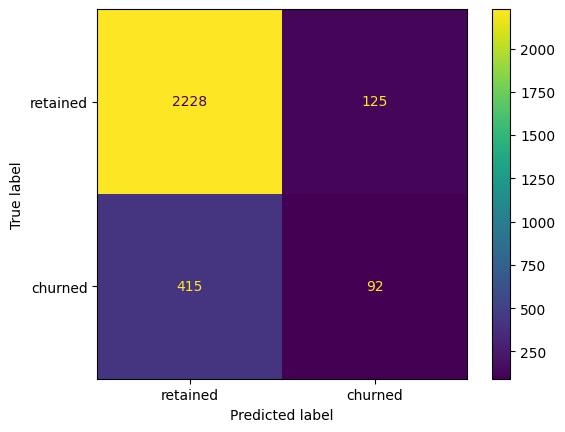

In [42]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

Task 14. Feature importance

Use the plot_importance function to inspect the most important features of your final model.

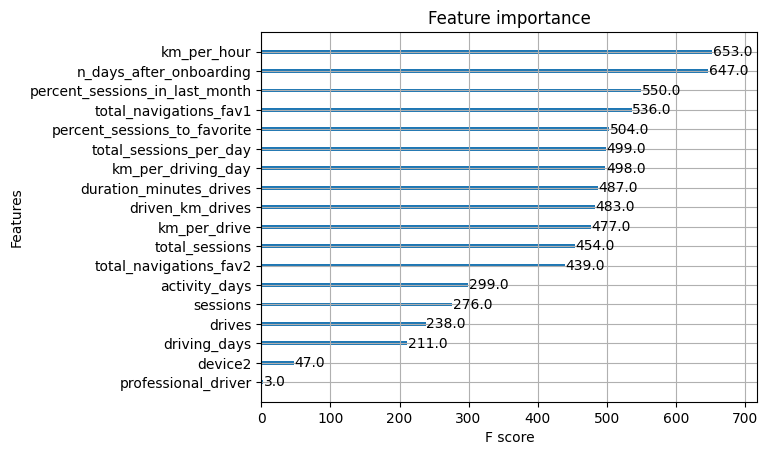

In [43]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (activity_days) very heavily in its final prediction.

If anything, this underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why you shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.

Even if you cannot use the model to make strong predictions, was the work done in vain? What insights can you report back to stakeholders?

Task 15. Conclusion

Now that you've built and tested your machine learning models, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

Questions:

Would you recommend using this model for churn prediction? Why or why not?

What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

What could you do to improve this model?

What additional features would you like to have to help improve the model?

Could you advise on using this model for churn prediction? Why or why not?** **testo in grassetto**

The suitability of this model depends on its intended application. If the model is intended to inform critical business decisions, it might not be the best choice due to its limited predictive power, particularly evident in its low recall score. However, if the model is primarily intended to guide further exploratory analyses, it could still offer some value.

**What was the tradeoff in splitting the data into training, validation, and test sets compared to just training and test sets?**

Dividing the data into three sets instead of two means that there is less data available for training the model. However, having a separate validation set allows for independent model selection, which ultimately leads to a more reliable evaluation of the chosen model's performance on the test set. This approach provides a better estimate of the model's future performance compared to a simple two-way split.

**What are the advantages of using logistic regression over ensemble tree-based models (such as random forest or XGBoost) for classification tasks?**

Logistic regression models offer simplicity and interpretability. By assigning coefficients to predictor variables, they not only identify the most influential features but also indicate the directionality of their impact on the target variable. In essence, logistic regression models provide insights into whether each feature positively or negatively correlates with the target in the final prediction.

**What are the advantages of using an ensemble of tree-based models like random forest or XGBoost over logistic regression for classification tasks?**

Tree-based model ensembles typically yield better predictive performance. When predictive power is paramount, tree-based models often outperform logistic regression (although not always). Moreover, they require less data preprocessing and fewer assumptions about the underlying distributions of predictor variables, making them easier to handle.

**How can this model be enhanced?**

One approach to improving the model is by engineering new features to capture more predictive signals, particularly those informed by domain knowledge. In this instance, engineered features accounted for a significant portion of the top predictive features used by the model. Additionally, reconstructing the model with different combinations of predictor variables can help minimize noise from irrelevant features.

**What additional features would be beneficial for improving the model?**

Having drive-level information for each user, such as drive times and geographic locations, would provide valuable insights. Moreover, more granular data on user interactions with the app, such as reporting or confirming road hazards, could enhance predictive accuracy. Lastly, knowing the monthly count of unique starting and ending locations inputted by each driver would offer further contextual information.